# Predykcja wartości samochodu na podstawie danych z serwisu Otomoto
## Mateusz Borowski

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import joblib
import shap

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from encoders import InfrequentEncoder, OutlierEncoder
from utils import print_metrics, print_cross_val_summary

sns.set()

In [69]:
df = pd.read_csv('data/otomoto_dataset.csv')
df.head()

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,rhd,target_price
0,audi,a6,2013.0,153817.0,1984.0,180.0,automatic,petrol,0.0,0.0,69900.0
1,skoda,fabia,2004.0,115000.0,1390.0,75.0,manual,petrol,0.0,0.0,8299.0
2,chevrolet,camaro,2012.0,299000.0,3600.0,323.0,automatic,petrol,0.0,0.0,54500.0
3,bmw,seria-3,2013.0,155000.0,1995.0,163.0,automatic,diesel,0.0,0.0,62000.0
4,renault,talisman,2017.0,167000.0,1600.0,130.0,automatic,diesel,0.0,0.0,52999.0


## Zapoznanie się ze zbiorem danych i wykrycie ewentualnych anomalii

In [70]:
df.shape

(206860, 11)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206860 entries, 0 to 206859
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   make             206860 non-null  object 
 1   model            206860 non-null  object 
 2   vehicle_year     206860 non-null  float64
 3   mileage          205506 non-null  float64
 4   engine_capacity  204662 non-null  float64
 5   engine_power     205262 non-null  float64
 6   gearbox          205466 non-null  object 
 7   fuel_type        206860 non-null  object 
 8   damaged          206860 non-null  float64
 9   rhd              206860 non-null  float64
 10  target_price     206860 non-null  float64
dtypes: float64(7), object(4)
memory usage: 17.4+ MB


In [72]:
df.isnull().sum()

make                  0
model                 0
vehicle_year          0
mileage            1354
engine_capacity    2198
engine_power       1598
gearbox            1394
fuel_type             0
damaged               0
rhd                   0
target_price          0
dtype: int64

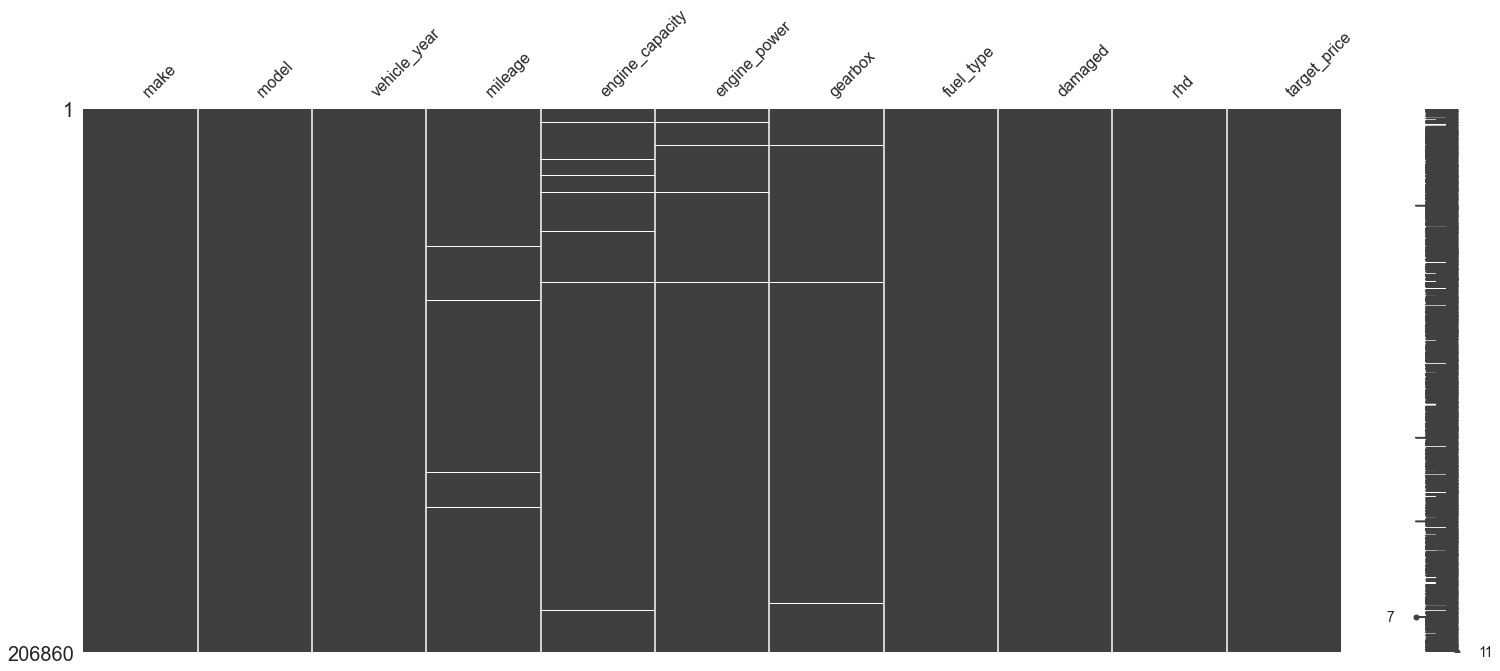

In [73]:
msno.matrix(df)
plt.show()

Wiersze zazwyczaj nie zawierają brakujących danych we wszystkich kolumnach, w których występują braki.

In [74]:
sum(df.duplicated())

4939

Występują powtarzające się rekordy

In [75]:
df = df.drop_duplicates()

In [76]:
df[(
    (df['target_price'] < 0) |
    (df['mileage'] < 0) |
    (df['vehicle_year'] < 1900) |
    (df['engine_capacity'] < 0) |
    (df['engine_power'] < 0)
    )].size

0

Brak błędnych wartości w danych

## EDA

### Podział na zbiory treningowe i testowe

In [77]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=128)

In [78]:
train_df = train_df.reset_index().drop(columns=['index'])
test_df = test_df.reset_index().drop(columns=['index'])

In [79]:
train_df.describe()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,rhd,target_price
count,141344.000000,1.405280e+05,139836.000000,140251.000000,141344.000000,141344.000000,1.413440e+05
mean,2012.121965,1.420721e+05,1868.236684,150.902318,0.039223,0.003290,6.080006e+04
std,6.449750,1.546583e+06,707.933493,76.712719,0.194127,0.057263,8.383108e+04
min,1917.000000,1.000000e+00,400.000000,1.000000,0.000000,0.000000,6.000000e+02
25%,2008.000000,5.130775e+04,1461.000000,105.000000,0.000000,0.000000,1.790000e+04
50%,2013.000000,1.402180e+05,1798.000000,136.000000,0.000000,0.000000,3.490000e+04
75%,2017.000000,2.000000e+05,1997.000000,170.000000,0.000000,0.000000,7.190000e+04
max,2021.000000,5.000000e+08,8285.000000,1500.000000,1.000000,1.000000,5.250000e+06


In [80]:
numeric_columns = train_df.select_dtypes('number').columns.to_list()
numeric_columns.remove('target_price') # target variable will be taken care of separately 
numeric_columns

['vehicle_year',
 'mileage',
 'engine_capacity',
 'engine_power',
 'damaged',
 'rhd']

In [81]:
train_df['rhd'].unique()

array([0., 1.])

In [82]:
train_df['damaged'].unique()

array([0., 1.])

Zmienne `rhd` i `damaged` to tak naprawdę zmienne kategoryczne

In [83]:
numeric_columns = [e for e in numeric_columns if e not in ('rhd', 'damaged')]

In [84]:
categorical_columns = train_df.select_dtypes('object').columns.to_list()
categorical_columns.extend(('rhd', 'damaged'))
categorical_columns

['make', 'model', 'gearbox', 'fuel_type', 'rhd', 'damaged']

### Rozkład zmiennej celu

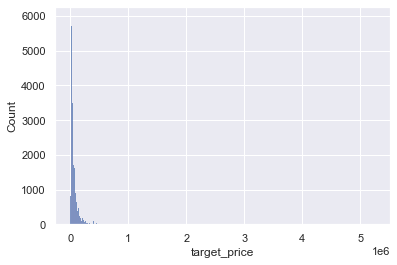

In [85]:
sns.histplot(train_df['target_price'])
plt.show()

### Rozkłady zmiennych numerycznych

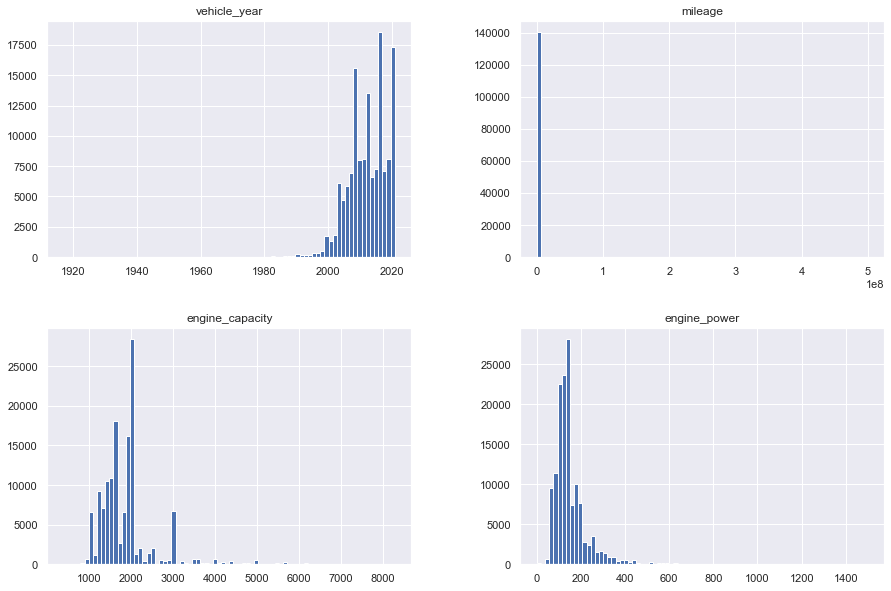

In [86]:
train_df[numeric_columns].hist(bins=80, figsize = (15,10), layout=(2,2))
plt.show()

### Wartości odstające

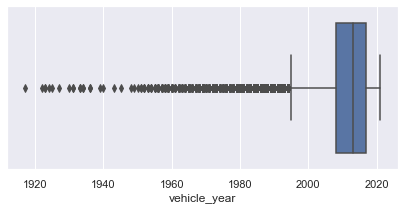

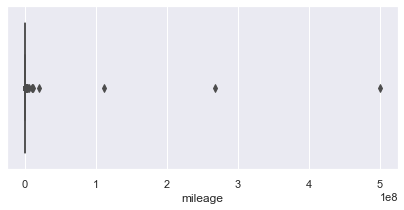

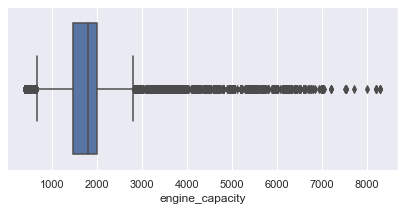

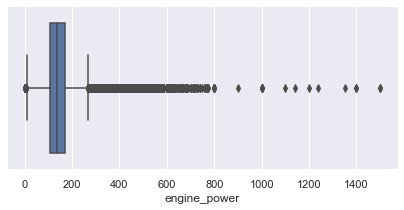

In [87]:
for col in numeric_columns:
    plt.figure(figsize=(7,3))
    sns.boxplot(data=train_df, x=col)
    plt.show()

### Zmienne kategoryczne

In [88]:
for col in categorical_columns:
    unique_vals = train_df[col].unique()
    if len(unique_vals) < 20:
        print(col, "unique elements:", unique_vals)
    else:
        print(col, "number of unique elements:", len(unique_vals))

make number of unique elements: 106
model number of unique elements: 1109
gearbox unique elements: ['automatic' 'manual' 'dual-clutch' nan 'cvt' 'automated-manual'
 'semi-automatic' 'automatic-stepless' 'automatic-stepless-sequential'
 'automatic-sequential' 'manual-sequential']
fuel_type unique elements: ['petrol' 'diesel' 'petrol-lpg' 'hybrid' 'electric' 'petrol-cng' 'etanol']
rhd unique elements: [0. 1.]
damaged unique elements: [0. 1.]


In [89]:
min_frequency = 100

for cat in categorical_columns:
    print(f"Liczba klas zmiennej {cat}: {train_df[cat].unique().size}.")
    print(f"Liczba klas pojawiających się mniej niż {min_frequency} razy: {sum(train_df[cat].value_counts() < min_frequency)}")

Liczba klas zmiennej make: 106.
Liczba klas pojawiających się mniej niż 100 razy: 66
Liczba klas zmiennej model: 1109.
Liczba klas pojawiających się mniej niż 100 razy: 830
Liczba klas zmiennej gearbox: 11.
Liczba klas pojawiających się mniej niż 100 razy: 6
Liczba klas zmiennej fuel_type: 7.
Liczba klas pojawiających się mniej niż 100 razy: 2
Liczba klas zmiennej rhd: 2.
Liczba klas pojawiających się mniej niż 100 razy: 0
Liczba klas zmiennej damaged: 2.
Liczba klas pojawiających się mniej niż 100 razy: 0


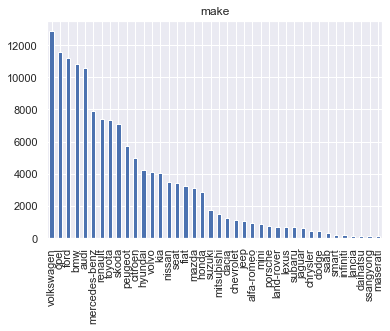

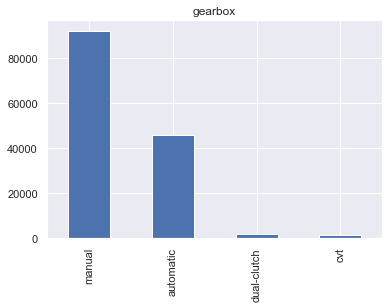

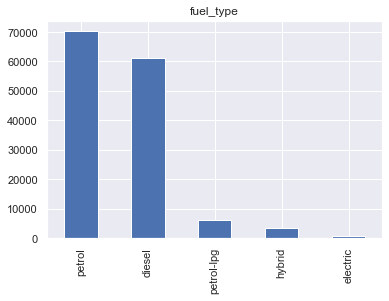

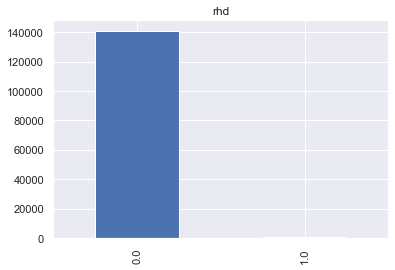

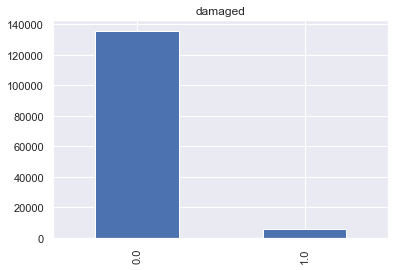

In [90]:
for col in categorical_columns:

    # wykres liczności dla zmiennej model byłby nieczytelny ze względu na dużą liczbę wartości
    if col == 'model':
        continue
    
    train_df[col].value_counts()[train_df[col].value_counts() > min_frequency].plot(kind='bar').set_title(col)
    plt.show()

### Zbadanie korelacji pearsona pomiędzy zmiennymi numerycznymi

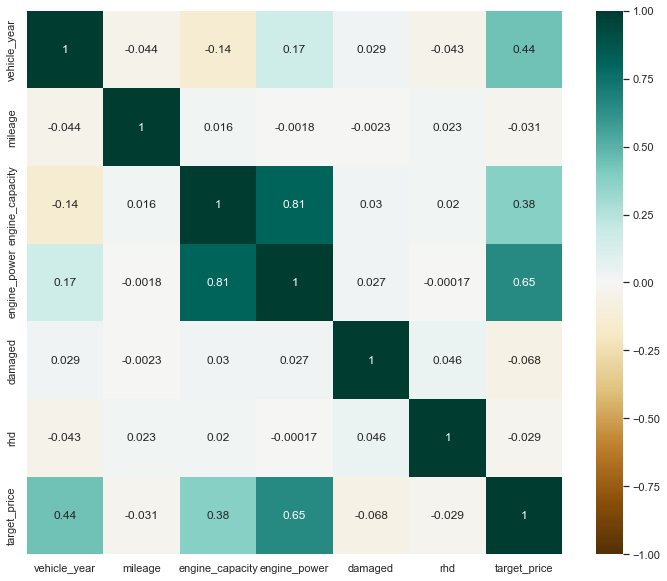

In [91]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(train_df.corr(), annot=True, vmin=-1, vmax=1, cmap="BrBG")
plt.show()

In [92]:
train_df.corr()['target_price'].abs().sort_values(ascending=False)

target_price       1.000000
engine_power       0.650263
vehicle_year       0.444519
engine_capacity    0.378204
damaged            0.068193
mileage            0.030935
rhd                0.028797
Name: target_price, dtype: float64

## Preprocessing

Poniższe transformacje mogą zostać zautomatyzowane za pomocą pipeline'ów

Przykładowe pipeline'y umieściłem w notebooku `pipelines_example.ipynb`

In [93]:
numeric_imputer = SimpleImputer(strategy='median')
outlier_enc = OutlierEncoder()
standarizer = StandardScaler()

onehot_cols = ['make', 'model', 'gearbox', 'fuel_type']
binary_cols = ['rhd', 'damaged']

categorical_imputer = SimpleImputer(strategy='constant', fill_value='Other')
infrequent_enc = InfrequentEncoder(min_frequency=100, col_names=onehot_cols)
onehot_enc = OneHotEncoder(handle_unknown='ignore')

In [94]:
X = train_df.drop(columns=['target_price'])
y = train_df['target_price']

X[numeric_columns] = numeric_imputer.fit_transform(X[numeric_columns])
X[numeric_columns] = outlier_enc.fit_transform(X[numeric_columns])
X[numeric_columns] = standarizer.fit_transform(X[numeric_columns])

X[onehot_cols] = categorical_imputer.fit_transform(X[onehot_cols])
X[onehot_cols] = infrequent_enc.fit_transform(X[onehot_cols])

one_hotted = onehot_enc.fit_transform(X[onehot_cols])

X = X.drop(columns=onehot_cols)
X = pd.concat([X, pd.DataFrame(one_hotted.toarray(), columns=onehot_enc.get_feature_names_out())], axis=1)

In [95]:
X.head()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,rhd,make_Other,make_alfa-romeo,make_audi,make_bmw,...,gearbox_automatic,gearbox_cvt,gearbox_dual-clutch,gearbox_manual,fuel_type_Other,fuel_type_diesel,fuel_type_electric,fuel_type_hybrid,fuel_type_petrol,fuel_type_petrol-lpg
0,1.310008,-1.629218,2.040114,2.208166,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.548112,0.867544,-1.339999,-0.742405,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.310008,1.590248,2.040114,2.208166,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.357638,-0.198375,-0.844524,-1.052991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-2.118522,-0.013923,2.040114,2.208166,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Feature selection

In [96]:
# Możnaby użyć, gdybym miał więcej czasu/lepsze podzespoły

# from sklearn.feature_selection import SequentialFeatureSelector

# sfs = SequentialFeatureSelector(
#     RandomForestRegressor(max_depth=10, random_state=128, n_jobs=-1),
#     n_features_to_select=25,
#     direction='forward',
#     scoring='neg_mean_squared_error',
#     cv=3,
#     n_jobs=-1
# )

# sfs.fit(X, y)

Model na potrzeby feature selection:

In [97]:
rf_feature_selection = RandomForestRegressor(max_depth=10, random_state=128, n_jobs=-1)
rf_feature_selection.fit(X, y)

RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=128)

In [98]:
importances = pd.Series(data=rf_feature_selection.feature_importances_, index=X.columns)
importances.sort_values(ascending=False, inplace=True)
importances.head(25)

vehicle_year            0.291525
engine_power            0.284830
gearbox_manual          0.154904
mileage                 0.097312
engine_capacity         0.049106
make_porsche            0.021366
make_Other              0.014496
fuel_type_petrol        0.013859
damaged                 0.011429
model_911               0.010155
fuel_type_diesel        0.008373
make_mercedes-benz      0.006684
model_Other             0.005836
fuel_type_petrol-lpg    0.003257
model_panamera          0.002679
model_other             0.002484
gearbox_dual-clutch     0.002175
model_mustang           0.001776
gearbox_automatic       0.001719
model_klasa-s           0.001680
gearbox_Other           0.001458
make_bmw                0.001356
make_audi               0.000954
fuel_type_electric      0.000892
make_dodge              0.000750
dtype: float64

Uwzględnijmy zmienne, których feature importance jest większy od 0.005

In [100]:
importance_threshold = 0.005

selected_features = importances[importances > importance_threshold].index.tolist()

In [101]:
X = X[selected_features]

## Model selection

In [102]:
scores_lr = cross_val_score(
    LinearRegression(n_jobs=-1),
    X, y,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

print_cross_val_summary(scores_lr)

-3839020514.42 neg_mean_squared_error with a standard deviation of 334025781.77


In [103]:
scores_dt = cross_val_score(
    DecisionTreeRegressor(max_depth=20, random_state=128),
    X, y,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

print_cross_val_summary(scores_dt)

-1813982703.02 neg_mean_squared_error with a standard deviation of 361024718.29


In [104]:
scores_rf = cross_val_score(
    RandomForestRegressor(max_depth=10, random_state=128, n_jobs=-1),
    X, y,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

print_cross_val_summary(scores_rf)

-1555178624.36 neg_mean_squared_error with a standard deviation of 360895117.88


Najlepiej sprawuje się las losowy, dlatego to właśnie go postaram się dopracować (w tym miejscu wciąż pozostaje miejsce do rozbudowy, możnaby sprawdzić jak sprawują się modele wykorzystujące gradient boosting, na przykład XGBoost, czy LightGBM)

## Hyperparameter tuning

In [166]:
rf_reg = RandomForestRegressor(random_state=128, n_jobs=-1)

params = {
    'n_estimators': np.linspace(50, 200, 31).astype(int),
    'max_depth': np.arange(5, 21).astype(int),
    'max_features': ['sqrt', 'log2']
}

In [167]:
clf = RandomizedSearchCV(rf_reg,
                         param_distributions=params,
                         cv=5,
                         n_jobs=-1,
                         n_iter=100,
                         scoring='neg_mean_squared_error',
                         random_state=128,
                         verbose=1
                        )

search = clf.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [168]:
clf.best_estimator_

RandomForestRegressor(max_depth=18, max_features='sqrt', n_estimators=170,
                      n_jobs=-1, random_state=128)

In [169]:
clf.best_params_

{'n_estimators': 170, 'max_features': 'sqrt', 'max_depth': 18}

In [170]:
joblib.dump(clf.best_estimator_, 'best_model.sav')

['best_model.sav']

## Model evaluation

In [171]:
# model = joblib.load('best_model.sav')

In [172]:
model = clf.best_estimator_

In [173]:
def transform_new_data(X_new):
    X_ = X_new.copy()

    X_[numeric_columns] = numeric_imputer.transform(X_[numeric_columns])
    X_[numeric_columns] = outlier_enc.transform(X_[numeric_columns])
    X_[numeric_columns] = standarizer.transform(X_[numeric_columns])

    X_[onehot_cols] = categorical_imputer.transform(X_[onehot_cols])
    X_[onehot_cols] = infrequent_enc.transform(X_[onehot_cols])

    one_hotted = onehot_enc.transform(X_[onehot_cols])

    X_ = X_.drop(columns=onehot_cols)
    X_ = pd.concat([X_, pd.DataFrame(one_hotted.toarray(), columns=onehot_enc.get_feature_names_out())], axis=1)

    X_ = X_[selected_features]

    return X_

In [175]:
y_hat = model.predict(X)
print_metrics(y, y_hat)

MSE: 557565372.3538404
RMSE: 23612.82220222395
MAE: 8400.709675433063
R2: 0.9206606271380021


In [176]:
X_test = test_df.drop(columns=['target_price'])
y_test = test_df['target_price']

X_test = transform_new_data(X_test)

y_test_hat = model.predict(X_test)

print_metrics(y_test, y_test_hat)

MSE: 1568618374.0164292
RMSE: 39605.78712784824
MAE: 11551.061725873584
R2: 0.795736751656674


Błąd średniokwadratowy wyniósł niecałe 40 tysięcy, co nie jest złym wynikiem, ale niewątpliwie pozostawia pole do poprawy. Przykładowe działania jakie możnaby podjąć to przeszukanie większej liczby hiperparametrów, czy klasteryzacja samochodów z intencją podziału na np. segment budżetowy, zwykłe samochody i samochody marki premium, a następnie stworzenie 3 modeli predykujących cenę dla każdego z tych klastrów.

Warty odnotowania jest fakt, że MAE jest wyraźnie niższe niż RMSE, co może oznaczać, że model myli się przy przewidywaniu ceny samochodów o wysokiej wartości, dlatego możnaby również spróbować przewidywać logarytm ceny, bądź spróbować wspomnianego wcześniej podejścia z klasteryzacją i budowie osobnego modelu dla każdego z klastrów.

W dalszej analizie powinno zbadać się problem przetrenowania modelu, ze względu na dość zauważalne różnice w osiągach modelu na zbiorze testowym i treningowym.

## XAI

In [177]:
np.random.seed(42)
samples_idx = np.random.randint(len(X_test), size=1000)
samples = X_test.iloc[samples_idx]

In [178]:
exp_shap = shap.Explainer(model.predict, X)
shap_values = exp_shap(samples)

Permutation explainer: 1001it [11:40,  1.41it/s]                          


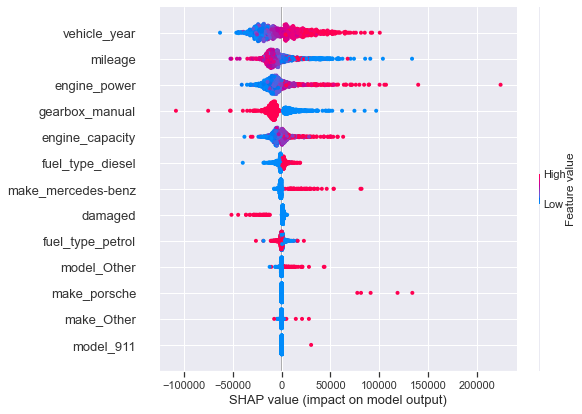

In [179]:
shap.plots.beeswarm(shap_values, max_display=14)

Na powyższym wykresie możemy zauważyć, że jest sporo zmiennych, których wartości dość jednoznacznie wpływają na zwiększenie, bądź zminiejszenie cany przewidywanej przez model.

Widać przykładowo, że niskie wartości w kolumnie `vehicle_year` zniejszają przewidywaną cenę, natomiast wysokie wartości ową cenę podnoszą. Podobny podział widać dla zmiennych takich jak: przebieg, moc silnika, typ skrzyni biegów, czy fakt, że marka samochodu to Mercedes. Ciekawa jest obserwacja zmiennej `damaged` - jeśli samochód jest sprawny (wartość 0 w tej kolumnie), to nie ma to wpływu na cenę, jednak jeśli model jest uszkodzony, to cena spada.

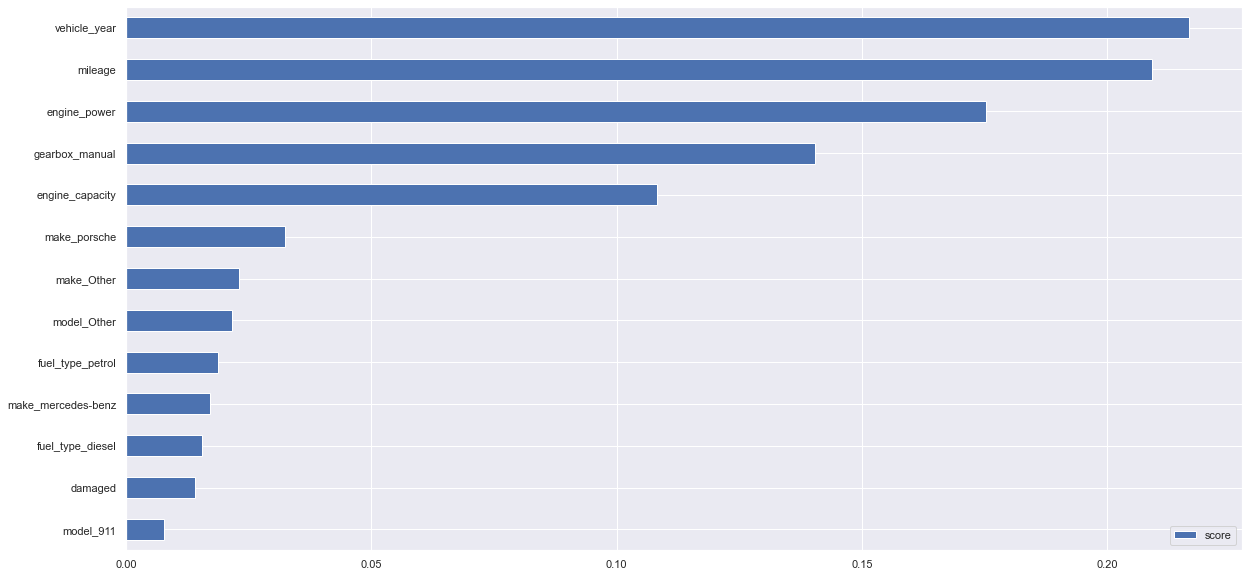

In [180]:
feature_importances = pd.DataFrame(
        data=model.feature_importances_,
        index=selected_features,
        columns=["score"]
    ).sort_values(by='score')

feature_importances.plot(kind='barh', figsize = (20,10))
plt.show()

Powyżej widać, że według modelu największy wpływ na finalną cenę przewidzianą przez model mają takie zmienne jak `vehicle_year`, `mileage`, czy `engine_power`, jednak wyraźnie widać, że model bazuje nie tylko na nich.

Poniżej widzimy analizę częściowej zależności trzech wspomnianych zmiennych.

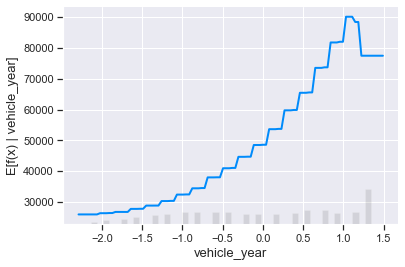

In [181]:
shap.partial_dependence_plot(
    0,
    model.predict,
    X,
    ice=False
)

Jak wyżej widać, cena modelu może różnić się nawet o 60 tysięcy, w zależności jedynie od tego ile pojazd ma lat.

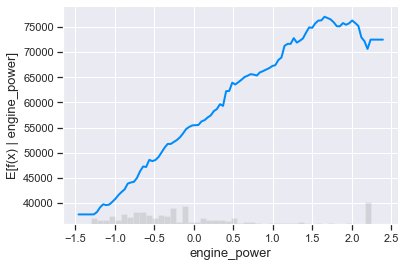

In [182]:
shap.partial_dependence_plot(
    1,
    model.predict,
    X,
    ice=False
)

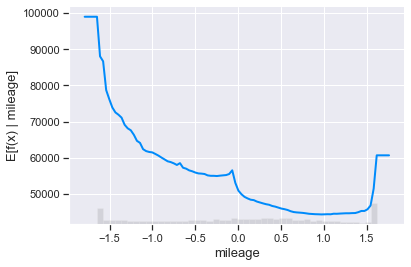

In [183]:
shap.partial_dependence_plot(
    3,
    model.predict,
    X,
    ice=False
)

Tutaj widzimy odwrotny trend niż przy wieku pojazdu. Im wyższy przebieg tego samego pojazdu, tym mniej jest on warty. Ciekawa, warta zbadania obserwacja ma miejsce dla wysokich wartości przebiegu.